In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import torch 
import numpy as np
from pyscf import gto, scf
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh,eigs
import scipy.linalg as la
from qiskit.circuit.library import RZGate, RXGate, RXXGate
import scipy.sparse as sp
import torch.nn.init as init


warnings.filterwarnings('ignore')

In [2]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 


def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=12
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(hamiltonian_matrix)
print(len(hamiltonian_matrix))


tensor([[ 0.2249+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.0281+0.0000j,  0.0494-0.4734j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0494+0.4734j,  0.3661+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.3661+0.0000j, -0.0494+0.4734j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.0494-0.4734j, -0.0281+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.2249+0.0000j]],
       dtype=torch.complex128)
4096


In [6]:
# Define the classical encoder neural network
class ClassicalEncoder(nn.Module):
    def __init__(self):
        super(ClassicalEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(128, 64), # Second layer with 14 inputs and 28 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(64, 32), # Third layer with 28 inputs and 56 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(32, 12), # Fourth layer reducing from 56 to 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(16, 8), # Fifth layer reducing from 28 to 14 outputs
            #n.ReLU(),
            #nn.Linear(8,4)
        )
    
    def forward(self, x):
        return self.fc(x)

encoder = ClassicalEncoder()
#print("The encoder is: ", encoder)

class QuantumCircuitModule:
    def __init__(self, num_qubits, depth):
        super(QuantumCircuitModule, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.params = torch.nn.Parameter(torch.rand((3 * num_qubits * depth + depth * (num_qubits - 1)), dtype=torch.float32) * 0.01)  # Small random initialization
        
        # Create a list of parameters for the quantum circuit, with correlations for avoiding barren plateaus
        self.theta = [Parameter(f'θ{i}') for i in range(len(self.params))]

    def forward(self, x):
        # Initialize the quantum circuit
        backend=Aer.get_backend('qasm_simulator')
        qc = QuantumCircuit(self.num_qubits, self.num_qubits)

        param_counter = 0
        
        # Apply initial rotations with a careful initialization
        

        for layer in range(self.depth):
            # Add rotation layers
            for qubit in range(self.num_qubits):
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rx(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
            
            # Add the entangling RXX gates in a pattern to increase entanglement gradually
            for qubit in range(self.num_qubits - 1):
                qc.rxx(self.theta[param_counter], qubit, (qubit + 1) % self.num_qubits)
                param_counter += 1

            # Add barrier to define layers clearly
        qc.barrier()

        # Add measurements
        qc.measure(range(self.num_qubits), range(self.num_qubits))
        #print(qc)

        # Bind the parameters to the values from the input
        param_values = [p.item() for p in self.params]
        qc_bound = qc.bind_parameters({self.theta[i]: param_values[i] for i in range(len(self.params))})

        # Execute the quantum circuit
        transpiled_circuit = transpile(qc_bound, backend)
        job = execute(transpiled_circuit, backend, shots=2048)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)

        expectation_values = []
        for i in range(12):
            # Calculate expectation value for each qubit
            p0 = counts.get('0' * i + '0' + '0' * (3 - i), 0) / 1024
            p1 = counts.get('0' * i + '1' + '0' * (3 - i), 0) / 1024
            expectation_value = p0 - p1
            expectation_values.append(expectation_value)

        # Convert the most common bitstring to numpy array and then to PyTorch tensor
        output_bitstring = max(counts, key=counts.get)
        output_data = np.array([int(bit) for bit in output_bitstring[::-1]])  # Reverse to match qubit ordering
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        #print(torch.tensor(expectation_values, dtype=torch.float32))
        #print(output_tensor)

        return torch.tensor(expectation_values, dtype=torch.float32)



# Define the classical decoder neural network
class ClassicalDecoder(nn.Module):
    def __init__(self):
        super(ClassicalDecoder, self).__init__()
        self.fc = nn.Sequential(
            #nn.Linear(4, 8),    # First layer with 4 inputs and 8 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(8, 16),   # Second layer with 8 inputs and 16 outputs
            #nn.ReLU(),          # Activation function
            nn.Linear(12, 32),  # Third layer with 16 inputs and 32 outputs
            nn.ReLU(),          # Activation function
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),  # Fourth layer reducing from 32 to 16 outputs
            nn.ReLU(),          # Activation function
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096)
            
        )
    
    def forward(self, x):
        return self.fc(x)

decoder = ClassicalDecoder()
#print("The decoder is: ", decoder)


class HybridModel(nn.Module):
    def __init__(self, num_qubits, depth):
        super(HybridModel, self).__init__()
        self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit_module = QuantumCircuitModule(num_qubits, depth)  # Initialize the quantum circuit module

    def forward(self, x):
        encoded= self.encoder(x)
        quantum_result = self.qcircuit_module.forward(encoded)  # Use the result from the quantum circuit module
        decoded = self.decoder(quantum_result)
        return decoded

# Initialize the model
num_qubits = 12  # or 8 for the N=8 case
depth = 1 # Can be increased for more complexity
model = HybridModel(num_qubits, depth)

In [7]:
def energy_expectation(output, hamiltonian):

    # Convert hamiltonian to double
    hamiltonian = hamiltonian.type(torch.double)

    # Convert output to double
    wavefunction = output.type(torch.double)

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(hamiltonian, norm_wavefunction)).real

    return energy

In [8]:
def print_gradient_norm(self, grad_input, grad_output):
    # grad_input is a tuple containing the gradients with respect to the inputs of the layer
    # grad_output is a tuple containing the gradients with respect to the outputs of the layer
    if grad_input is not None and grad_input[0] is not None:
        input_norm = grad_input[0].norm()
        #print(f'Layer: {self.__class__.__name__} | Gradient norm (input): {input_norm}')
    if grad_output is not None and grad_output[0] is not None:
        output_norm = grad_output[0].norm()
        #print(f'Layer: {self.__class__.__name__} | Gradient norm (output): {output_norm}')

# Register hooks on all layers of the model that have weights
for name, layer in model.named_modules():
    if hasattr(layer, 'weight'):
        # Register a hook on the layer
        layer.register_full_backward_hook(print_gradient_norm)


# Sample input
input_data = torch.rand(4096, requires_grad=True)  # Example input
#input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241, 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
#print("The model parameters are: ", model.parameters)
# Add weight decay to the optimizer (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 10
loss_values = []

loss_function = nn.MSELoss()


for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    loss = energy_expectation(output,hamiltonian_matrix)
    # Check if loss requires grad
    if not loss.requires_grad:
        raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f'NaN gradient in {name}')
            break
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 1/10, Loss: -0.05070722375690684
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.9990])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 2/10, Loss: 0.015020630711853694
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 3/10, Loss: -0.5276065911710299
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 4/10, Loss: -1.1808634553599884
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.9990])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 5/10, Loss: -2.0916577820610778
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 6/10, 

In [6]:
import scipy.linalg as la

def find_lowest_eigenvalue(matrix):
    # Compute all eigenvalues, but only the first eigenvectors
    eigenvalues, _ = la.eigh(matrix, eigvals=(0, 0))
    return eigenvalues[0]

# Assuming large_matrix is your matrix
lowest_eigenvalue = find_lowest_eigenvalue(hamiltonian_matrix)
print("Lowest Eigenvalue:", lowest_eigenvalue)


Lowest Eigenvalue: -6.890957156811205


In [22]:
# for the no pqc ground state approximation was: -4.239352522251876
# for the pqc ground state: -4.253164531632698


### For N=4 SYK Model

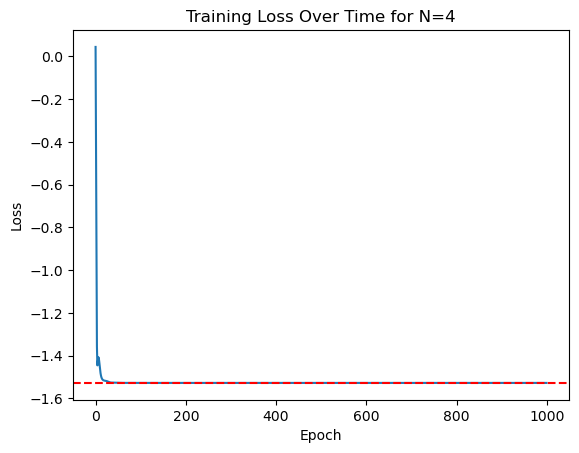

In [24]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=4')
plt.show()

### For N=5 SYK Model

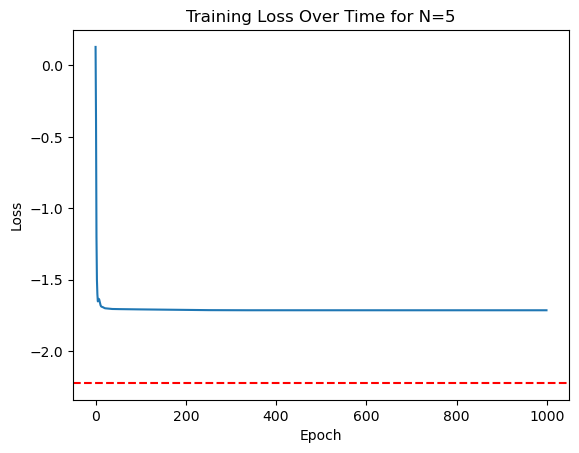

In [31]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=5')
plt.show()

### For N=8 SYK Model

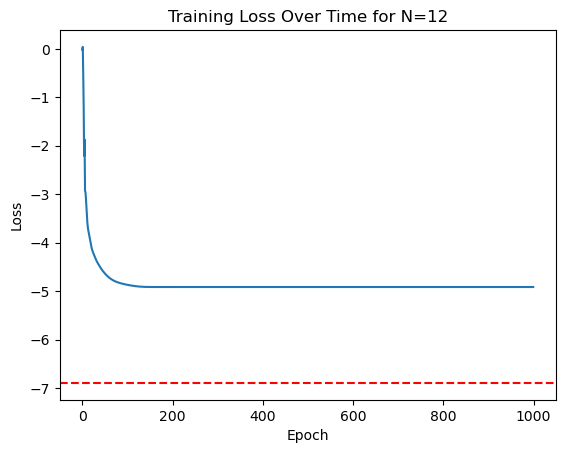

In [7]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=12')
plt.show()

## For Actual VQE for TFD

In [67]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


# Define a simple parameterized circuit as the ansatz
def create_ansatz(num_qubits):
    depth=4
    # Define the number of parameters for the rotation gates
    num_params_per_rotation_layer = 3 * num_qubits
    # Define the number of parameters for the RXX gates
    num_params_per_rxx_layer = num_qubits // 2
    # Calculate the total number of parameters per layer
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    # Calculate the total number of parameters for all layers
    total_params = depth * num_params_per_layer

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    param_counter = 0  # Counter for the parameters

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(params[param_counter], qubit)
            param_counter += 1
            qc.rx(params[param_counter], qubit)
            param_counter += 1
            qc.rz(params[param_counter], qubit)
            param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1

    return qc, params



num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = ADAM(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvaluef
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


128
The VQE given lowest eigenvalue is:  -3.3203581312170023
Exact Solver Result: -3.8201646988741342


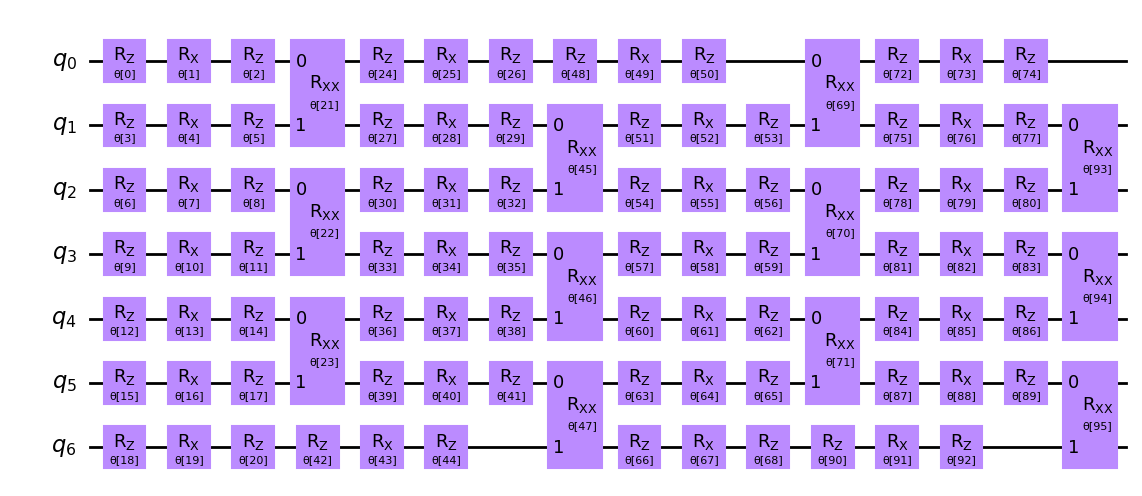

In [68]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')


In [17]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


from qiskit.circuit import QuantumCircuit, ParameterVector

def create_ansatz(num_qubits):
    depth = 4
    # Define the number of parameters for the rotation gates
    num_params_per_rotation_layer = 3 * num_qubits
    # Define the number of parameters for the RXX gates
    num_params_per_rxx_layer = num_qubits // 2
    # Calculate the total number of parameters per layer
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    # Calculate the total number of parameters for all layers
    total_params = depth * num_params_per_layer

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    
    # Initialize counters for Rz and other gates separately
    rz_param_counter = 0
    other_param_counter = num_qubits * depth

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            # Rz gates are numbered sequentially across all layers
            qc.rz(params[rz_param_counter], qubit)
            rz_param_counter += 1
            
            # Rx and second Rz use a different counter
            qc.rx(params[other_param_counter], qubit)
            other_param_counter += 1
            qc.rz(params[other_param_counter], qubit)
            other_param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(params[other_param_counter], qubit, qubit + 1)
                other_param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(params[other_param_counter], qubit, qubit + 1)
                other_param_counter += 1

    return qc, params




num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = SPSA(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvaluef
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


256
The VQE given lowest eigenvalue is:  -3.7855274133028596
Exact Solver Result: -5.3155751414375985


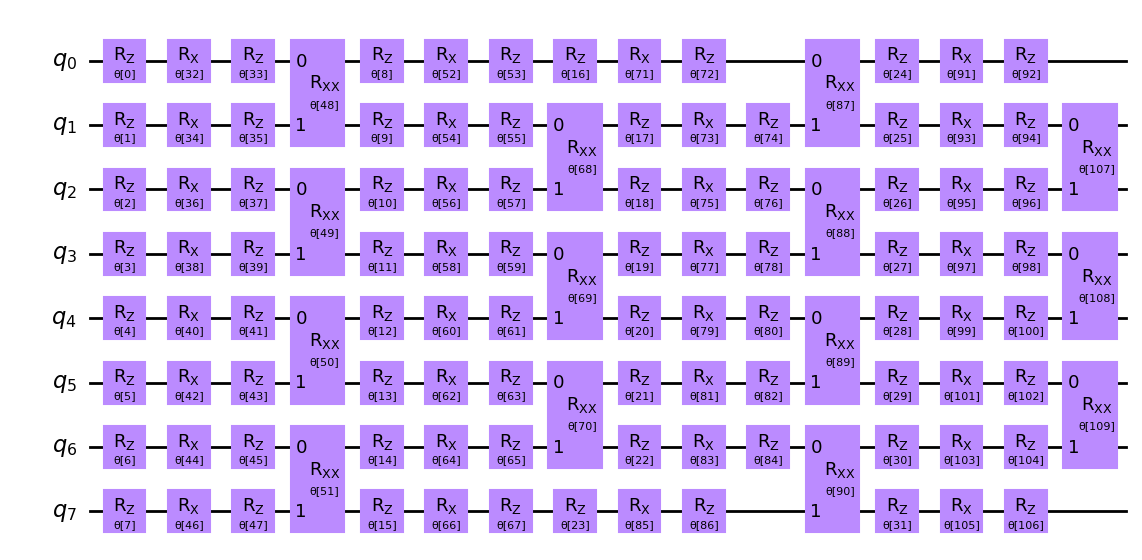

In [18]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')


In [3]:
"""

def create_ansatz(num_qubits):
    depth=4
    # Each layer has 3 rotations per qubit and half the number of qubits RXX gates
    num_params_per_rotation_layer = 3 * num_qubits
    num_params_per_rxx_layer = num_qubits // 2
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    total_params = depth * num_params_per_layer

    # Create a list of parameters
    params = [Parameter(f'θ{i}') for i in range(total_params)]
    qc = QuantumCircuit(num_qubits)

    # Assign parameters layer by layer
    for layer in range(depth):
        # Assign parameters for rotation gates
        for qubit in range(num_qubits):
            param_idx = layer * num_params_per_layer + qubit * 3
            qc.rz(params[param_idx], qubit)
            qc.rx(params[param_idx + 1], qubit)
            qc.rz(params[param_idx + 2], qubit)

        # Assign parameters for RXX gates in the layer
        for qubit in range(0, num_qubits, 2):
            param_idx = layer * num_params_per_layer + num_params_per_rotation_layer + qubit // 2
            qc.rxx(params[param_idx], qubit, qubit + 1)

    return qc, params
"""

"\n\ndef create_ansatz(num_qubits):\n    depth=4\n    # Each layer has 3 rotations per qubit and half the number of qubits RXX gates\n    num_params_per_rotation_layer = 3 * num_qubits\n    num_params_per_rxx_layer = num_qubits // 2\n    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer\n    total_params = depth * num_params_per_layer\n\n    # Create a list of parameters\n    params = [Parameter(f'θ{i}') for i in range(total_params)]\n    qc = QuantumCircuit(num_qubits)\n\n    # Assign parameters layer by layer\n    for layer in range(depth):\n        # Assign parameters for rotation gates\n        for qubit in range(num_qubits):\n            param_idx = layer * num_params_per_layer + qubit * 3\n            qc.rz(params[param_idx], qubit)\n            qc.rx(params[param_idx + 1], qubit)\n            qc.rz(params[param_idx + 2], qubit)\n\n        # Assign parameters for RXX gates in the layer\n        for qubit in range(0, num_qubits, 2):\n            param

## Sample VQE

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
df= pd.read_csv('SYK_results.csv')
df

,Experiment_run,true_energy,hybrid_model_energy,difference,N
0,experiment_number_0,-5.315575,-2.777270,88.159720,8
1,experiment_number_1,-1.528238,-1.527674,0.039820,4
2,experiment_number_2,-2.745392,-2.095270,31.023244,6
3,experiment_number_3,-2.222125,-1.707276,29.687416,5
4,experiment_number_4,-5.315575,-2.825043,88.158857,8
5,experiment_number_5,-2.222125,-1.713536,29.643425,5
6,experiment_number_6,-1.528238,-1.527714,0.034272,4
7,experiment_number_7,-0.020000,0.000000,inf,2
8,experiment_number_8,-0.030000,-0.030000,0.000003,3
9,experiment_number_9,-1.528238,-1.527714,0.034271,4


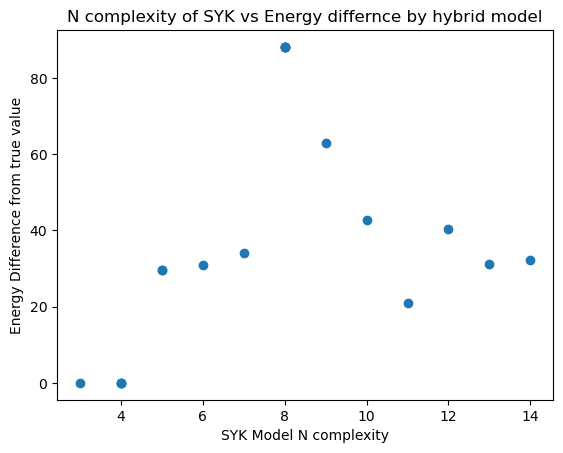

In [16]:
x= df['N']
y= df['difference']
plt.scatter(x,y)
plt.xlabel("SYK Model N complexity")
plt.ylabel("Energy Difference from true value")
plt.title("N complexity of SYK vs Energy differnce by hybrid model")
plt.show()

In [10]:
num_qubits = 8
depth = 4
num_params_per_rotation_layer = 3 * num_qubits
num_params_per_rxx_layer = num_qubits // 2
num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
total_params = depth * num_params_per_layer    

In [11]:
print(total_params)

112


In [93]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


# Define a simple parameterized circuit as the ansatz
def create_ansatz(num_qubits):
    depth=4
    # Define the total number of parameters, accounting for rotations and Rxx gates
    num_rotation_params = 3 * num_qubits * depth
    num_rxx_params = depth * (num_qubits - 1)  # One Rxx gate between each pair per layer
    total_params = num_rotation_params + num_rxx_params

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    qc = QuantumCircuit(num_qubits)
    param_counter = 0  # Counter for the parameters

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(params[param_counter], qubit)
            param_counter += 1
            qc.rx(params[param_counter], qubit)
            param_counter += 1
            qc.rz(params[param_counter], qubit)
            param_counter += 1
        
        # Add the Rxx gates for the layer, creating a 'staircase' pattern
        for qubit in range(0, num_qubits - 1):
            # Skip the connection to create the staircase pattern
            if layer % 2 == 0 and qubit % 2 == 0:
                continue
            if layer % 2 == 1 and qubit % 2 == 1:
                continue
            # Apply the Rxx gate
            qc.rxx(params[param_counter], qubit, qubit + 1)
            param_counter += 1


    return qc, params



num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = ADAM(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvalue
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


256
The VQE given lowest eigenvalue is:  -5.043611022848577
Exact Solver Result: -5.31557514143759


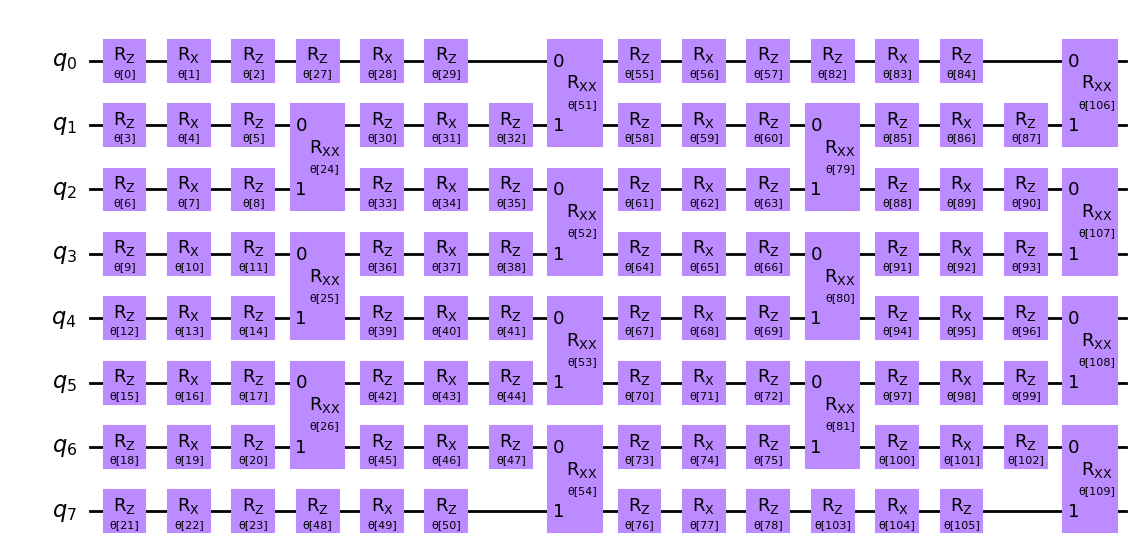

In [95]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')


In [84]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import RXXGate

def create_tfd_ansatz(num_qubits, depth):
    # Create a parameter for each rotation gate and RXX gate
    total_params = 3 * num_qubits * depth  # Rotation gates
    # Assuming the depth is 1 for the pattern to match the given circuit
    rxx_params = num_qubits - 1  # RXX gates per layer
    total_params += rxx_params * depth
    
    # Initialize the quantum circuit for n qubits
    circuit = QuantumCircuit(num_qubits)
    params = [Parameter(f'θ{i}') for i in range(total_params)]
    param_counter = 0
    
    for d in range(depth):
        # Apply Rz, Rx, Rz rotations to each qubit
        for q in range(num_qubits):
            circuit.rz(params[param_counter], q)
            param_counter += 1
            circuit.rx(params[param_counter], q)
            param_counter += 1
            circuit.rz(params[param_counter], q)
            param_counter += 1
        
        # Apply RXX gates in the interleaved "zipper" pattern
        for q in range(0, num_qubits - 1):
            if (d % 2 == 0 and q % 2 == 0) or (d % 2 == 1 and q % 2 == 1):
                circuit.append(RXXGate(params[param_counter]), [q, q + 1])
                param_counter += 1
                circuit.barrier()

    return circuit, params

# Example usage for 8 qubits and 1 layer deep
num_qubits = 8
depth = 1
circuit, parameters = create_tfd_ansatz(num_qubits, depth)

# Output the circuit diagram
print(circuit.draw(output='text'))


      ┌────────┐ ┌────────┐ ┌────────┐┌───────────┐ ░               ░ »
q_0: ─┤ Rz(θ0) ├─┤ Rx(θ1) ├─┤ Rz(θ2) ├┤0          ├─░───────────────░─»
      ├────────┤ ├────────┤ ├────────┤│  Rxx(θ24) │ ░               ░ »
q_1: ─┤ Rz(θ3) ├─┤ Rx(θ4) ├─┤ Rz(θ5) ├┤1          ├─░───────────────░─»
      ├────────┤ ├────────┤ ├────────┤└───────────┘ ░ ┌───────────┐ ░ »
q_2: ─┤ Rz(θ6) ├─┤ Rx(θ7) ├─┤ Rz(θ8) ├──────────────░─┤0          ├─░─»
      ├────────┤┌┴────────┤┌┴────────┤              ░ │  Rxx(θ25) │ ░ »
q_3: ─┤ Rz(θ9) ├┤ Rx(θ10) ├┤ Rz(θ11) ├──────────────░─┤1          ├─░─»
     ┌┴────────┤├─────────┤├─────────┤              ░ └───────────┘ ░ »
q_4: ┤ Rz(θ12) ├┤ Rx(θ13) ├┤ Rz(θ14) ├──────────────░───────────────░─»
     ├─────────┤├─────────┤├─────────┤              ░               ░ »
q_5: ┤ Rz(θ15) ├┤ Rx(θ16) ├┤ Rz(θ17) ├──────────────░───────────────░─»
     ├─────────┤├─────────┤├─────────┤              ░               ░ »
q_6: ┤ Rz(θ18) ├┤ Rx(θ19) ├┤ Rz(θ20) ├──────────────░───────────

In [12]:

def run_quantum_circuit(params):
    # Ensure input params is a list of values
    num_qubits= len(params)
    depth=5
    num_rotation_params = 3 * num_qubits * depth
    num_rxx_params = depth * (num_qubits - 1)  # One Rxx gate between each pair per layer
    total_params = num_rotation_params + num_rxx_params

    param_values = [params[i].item() for i in range(len(params))]
    
    # Create a list of parameters for the quantum circuit
    theta = [Parameter(f'θ{i}') for i in range(total_params)]
    param_counter = 0
    
    # Initialize the quantum circuit
    qc = QuantumCircuit(len(params), len(params))

    
    # Apply initial rotations
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(theta[qubit], qubit)
            param_counter += 1
            qc.rx(theta[qubit], qubit)
            param_counter += 1
            qc.rz(theta[qubit], qubit)
            param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(theta[qubit], qubit, qubit + 1)
                param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(theta[qubit], qubit, qubit + 1)
                param_counter += 1

    #print(param_counter)
    #print(len(theta))


    qc.barrier()

    # Add measurements
    qc.measure(range(len(params)), range(len(params)))
    #print(qc)
    
    # Bind the parameters to the values from the input
    qc_bound = qc.bind_parameters({theta[i]: param_values[i] for i in range(len(params))})
    
    # Execute the quantum circuit
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qc_bound, backend)
    job = execute(transpiled_circuit, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(transpiled_circuit)
    
    # Plotting is handled outside, just return counts or process further as needed
    
    # Convert the most common bitstring to numpy array and then to PyTorch tensor
    output_bitstring = max(counts, key=counts.get)
    output_data = np.array([int(bit) for bit in output_bitstring[::-1]])  # Reverse to match qubit ordering
    output_tensor = torch.tensor(output_data, dtype=torch.float32)
    
    return output_tensor


In [1]:
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import Operator, Pauli
import numpy as np

def parse_hamiltonian_line(line):
    """ Parses a line of the Hamiltonian file and returns a Qiskit operator. """
    parts = line.strip().split(" => ")
    coefficient = float(parts[0])
    terms = eval(parts[1])
    
    # Initialize operator strings for X, Y, Z, and I
    operator_str = ['I'] * num_qubits  # num_qubits should be defined as per your system
    
    for term in terms:
        qubit, pauli_char = term
        operator_str[qubit] = pauli_char

    operator_str = ''.join(operator_str)
    operator = PauliSumOp(Pauli(operator_str), coefficient)
    return operator

def construct_hamiltonian_from_file(file_path):
    """ Constructs the Hamiltonian from the file. """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Skip the first line as it contains energy values, not part of the Hamiltonian
    hamiltonian = sum(parse_hamiltonian_line(line) for line in lines[1:])
    return hamiltonian


def extract_pauli_term(line):
    parts = line.split("=>")
    coefficient = float(parts[0].strip())
    terms_str = parts[1].strip()
    terms = []
    
    # Manually parse the terms
    terms_str = terms_str[1:-1]  # Remove the outer parentheses
    term_parts = terms_str.split('),')
    
    for term in term_parts:
        term = term.strip(' ,()')
        qubit, pauli_char = term.split(',')
        qubit = int(qubit)
        pauli_char = pauli_char.strip("' ")
        terms.append((qubit, pauli_char))
    
    return coefficient, terms

def construct_hamiltonian_from_terms(lines, N):
    def sx(i):
        return Operator(Pauli(label='I'*(i)+'X'+'I'*(N-i-1)))
    
    def sy(i):
        return Operator(Pauli(label='I'*(i)+'Y'+'I'*(N-i-1)))

    def sz(i):
        return Operator(Pauli(label='I'*(i)+'Z'+'I'*(N-i-1)))

    hamiltonian = 0
    for line in lines:
        coef, pauli_terms = extract_pauli_term(line)
        pauli_string = 1
        for q_ind, pauli_choice in pauli_terms:
            q_ind = q_ind  # Python is already 0-indexed
            if pauli_choice == 'X':
                pauli_string = np.kron(pauli_string, sx(q_ind).data)
            elif pauli_choice == 'Y':
                pauli_string = np.kron(pauli_string, sy(q_ind).data)
            elif pauli_choice == 'Z':
                pauli_string = np.kron(pauli_string, sz(q_ind).data)
        hamiltonian += coef * pauli_string
    return hamiltonian

def read_hamiltonian(fname, N):
    with open(fname, 'r') as file:
        lines = file.readlines()
    SYK_energies = [float(x) for x in lines[0].split(',')]
    left_lines = lines[1:len(lines)//2]
    right_lines = lines[len(lines)//2:-N]
    int_lines = lines[-N:]

    h_L = construct_hamiltonian_from_terms(left_lines, N)
    h_R = construct_hamiltonian_from_terms(right_lines, N)
    h_int = construct_hamiltonian_from_terms(int_lines, N)
    return h_L, h_R, h_int, SYK_energies

def read_annihilation(fname, N):
    with open(fname, 'r') as file:
        lines = file.readlines()
    return construct_hamiltonian_from_terms(lines, N)

/var/folders/xw/9h0k4l0555nf2zvvvddq0hm00000gn/T/ipykernel_20441/3772730325.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow.primitive_ops import PauliSumOp


In [2]:
syk_ham= read_hamiltonian("/Users/rohitganti/Desktop/HybridQuantumClassicalEncoder-MolecularSystems/SYK_Hamiltonian_HA_Model/SYK_Implementation_of_TFD_VQE/data/SYK_ham_8_0_0.01.txt", 8)
syk_ham

/var/folders/xw/9h0k4l0555nf2zvvvddq0hm00000gn/T/ipykernel_20441/3772730325.py:60: DeprecationWarning: The 'label' keyword argument of 'Pauli' is deprecated as of Qiskit Terra 0.17 and will be removed in version 0.23 or later. Pass the label positionally instead, such as 'Pauli("XYZ")'.
  return Operator(Pauli(label='I'*(i)+'Z'+'I'*(N-i-1)))


: 

In [9]:
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
from qiskit.opflow import Z, StateFn, PauliExpectation, CircuitSampler, I
from qiskit.quantum_info import Operator
import numpy as np
# Define a simple variational circuit
def variational_circuit(params):
    qc = QuantumCircuit(4)  # Adjusted for an 8-qubit system
    # Assuming a simple pattern for demonstration; adapt as needed
    for i in range(4):
        qc.rz(params[i], i)  # Apply Rx with a parameter for each qubit
        qc.rx(params[i], i)
        qc.rz(params[i], i)
    
    # Example entanglement
    for i in range(7):
        qc.rxx(i, i + 1, i)
    
    return qc


# Hamiltonian for which we want to find the ground state
H = Z ^ I ^ I  # Example: Z on the first qubit, I (identity) on the others

H_matrix = Operator(Z ^ I ^ I).data


backend = Aer.get_backend('statevector_simulator')

def objective_function(params):
    # Ensure params has 8 parameters for the 8-qubit system
    qc = variational_circuit(params)
    #print(qc.draw('text'))

    transpiled_qc = transpile(qc, backend)
    result = execute(transpiled_qc, backend).result()
    statevector = result.get_statevector(qc)
    
    # Compute the expectation value
    expectation_value = np.dot(statevector.conj().T, np.dot(H_matrix, statevector)).real
    
    return expectation_value


import torch
from torch import nn, optim

# Dummy neural network for demonstration
nn_model = nn.Sequential(
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 8)
)

# Function to adjust parameters using the neural network
def adjust_params_with_nn(params):
    params = torch.tensor(params, requires_grad=True)
    optimized_params = nn_model(params)
    return optimized_params.detach().numpy()


# Initial parameters for the variational circuit
initial_params = torch.rand(8, requires_grad=True)

# Optimizer setup
optimizer = optim.Adam([initial_params], lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


for i in range(1000):
    optimizer.zero_grad()
    
    # Compute loss
    loss_value = objective_function(initial_params.data.numpy())
    loss = torch.tensor(loss_value, requires_grad=True)

    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # Adjust parameters (conceptually using the neural network)
    adjusted_params = adjust_params_with_nn(initial_params.data.numpy())
    
    # Update parameters manually (for demonstration purposes)
    with torch.no_grad():
        initial_params[:] = torch.from_numpy(adjusted_params)
    
    print(f"Iteration {i+1}, Energy: {loss.item()}")

CircuitError: 'Index 4 out of range for size 4.'

In [11]:
from qiskit.quantum_info import Operator
from numpy.linalg import eig

# Define the Hamiltonian matrix
# For Z ⊗ I ⊗ I, the matrix is 8x8

# Calculate eigenvalues
eigenvalues, _ = eig(hamiltonian_matrix)

# Find the lowest eigenvalue
lowest_eigenvalue = np.min(eigenvalues)

print(f"The lowest eigenvalue of the Hamiltonian is: {lowest_eigenvalue.real}")


The lowest eigenvalue of the Hamiltonian is: -5.315575141437597


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, ParameterVector

class UnifiedHybridModel(nn.Module):
    def __init__(self, input_dim, output_dim, qubits=4):
        super(UnifiedHybridModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.qubits = qubits

        # A unified parameter vector for both classical and quantum parameters
        self.params = ParameterVector('theta', length=input_dim + qubits + output_dim)

        # Classical-to-Quantum Interface: Maps input_dim to qubits
        self.pre_quantum_layer = nn.Linear(input_dim, qubits)

        # Quantum-to-Classical Interface: Maps qubits to output_dim
        self.post_quantum_layer = nn.Linear(qubits, output_dim)

    def forward(self, x):
        # Classical Encoding
        encoded = self.pre_quantum_layer(x)

        # Quantum Circuit Execution as a 'Layer'
        quantum_output = self.run_quantum_circuit(encoded)

        # Classical Decoding
        decoded = self.post_quantum_layer(quantum_output)
        return decoded

    def run_quantum_circuit(self, params):
        # Define the quantum circuit with parametrized gates
        
        qc = QuantumCircuit(self.qubits)
        paras= []
        for i in params:
            paras.append(i[0])
        for i in range(self.qubits):
            #param_value = params[i].item()
            qc.rx(float(paras[0]), i)


        # Execution and measurement
        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        result = job.result().get_statevector(qc)
        
        # Process the quantum execution result
        # Note: This step may involve more sophisticated processing based on the nature of your problem
        processed_result = self.process_quantum_result(result)
        return processed_result

    def process_quantum_result(self, result):
        # Placeholder for processing the quantum result
        # Convert result to tensor or manipulate as needed
        return torch.tensor([abs(amplitude)**2 for amplitude in result], dtype=torch.float32)

# Example usage
model = UnifiedHybridModel(input_dim=10, output_dim=5).double()
input_data = torch.rand((1, 10), dtype=torch.float32)  # Example input
output = model(input_data)

# Define optimizer and loss for training
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()

# Example training loop (simplified)
for epoch in range(100):
    optimizer.zero_grad()
    output = model(input_data)
    loss = loss_function(output, torch.rand((1, 5), dtype=torch.float32))  # Example target
    loss.backward()
    optimizer.step()


RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double